---
# mix content and style in reconstruction an image

---

## Import libraries and set up environment

In [1]:
import torch
from torch import nn
import torch.optim as optim

from torchvision.models.vgg import vgg19, VGG19_Weights
from torchvision import transforms

from PIL import Image

constants

In [2]:
CONTENT_IMAGE_PATH = "../data/dog.jpg"
STYLE_IMAGE_PATH = "../data/starry_night.jpg"

In [20]:
# model constants
RANDOM_SEED = 42
LR = 0.01
NUM_ITERATION = 1000
CONTENT_WEIGHT = 0.01

Set up model

In [3]:
weights = VGG19_Weights.DEFAULT
model = vgg19(weights=weights)
model.eval()
transform = weights.transforms()

Freeze the VGG model parameters

In [4]:
for param in model.parameters():
    param.requires_grad = False

In [5]:
content_image = Image.open(CONTENT_IMAGE_PATH)
style_image = Image.open(STYLE_IMAGE_PATH)

# style morphing
**change style of an image based on an other image**

*content image tensor*

In [6]:
def image_to_tensor(image):
    image_t = transform(content_image)
    image_t.requires_grad = False
    return image_t

In [7]:
content_image_t = image_to_tensor(content_image)
_, width, height = content_image_t.shape
print(f"content image shape: \n width: {width}, height: {height}")

content image shape: 
 width: 224, height: 224


*style image tensor*

In [9]:
style_image_t = image_to_tensor(style_image)
_, width, height = style_image_t.shape
print(f"style image shape: \n  width: {width}, height: {height}")

style image shape: 
  width: 224, height: 224


In [10]:
def generate_white_noise_image(
    width,
    height,
):
    white_noise_image = torch.randn(3, width, height)
    white_noise_image = transform(white_noise_image)
    white_noise_image.requires_grad = True
    return white_noise_image

to visualize the image

In [11]:
def tensor_to_image(image_t):
    return transforms.Compose([transforms.ToPILImage()])(
        image_t.squeeze(0).cpu().clone().detach()
    )

In [12]:
white_noise_image_t = generate_white_noise_image(width, height)
print(white_noise_image_t.requires_grad)

True


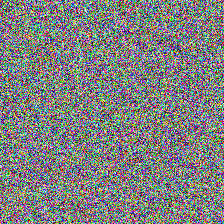

In [13]:
tensor_to_image(white_noise_image_t)

In [14]:
def get_features(model, x):
    """
    forward pass and get the features for all layers
    """
    features = []
    features = {}
    for i, layer in enumerate(model.features):
        x = layer(x)
        features[i] = x
    return features

In [15]:
def gram(features):
    a, b, c = features.shape
    t = features.view(a, b * c)
    gram = torch.mm(t, t.t())
    return gram

### loss function

content loss

In [16]:
def loss_content(features_1, features_2, layer):
    white_noise_features_for_layer = features_1[layer]
    real_image_features_for_layer = features_2[layer]
    loss = nn.MSELoss()(white_noise_features_for_layer, real_image_features_for_layer)
    return loss

style loss

In [17]:
def loss_style(features_1, features_2, layer):
    features_1_for_layer = features_1[layer]
    gram_1 = gram(features_1_for_layer )

    features_2_for_layer = features_2[layer]
    gram_2 = gram(features_2_for_layer)

    loss = nn.MSELoss()(gram_1, gram_2)
    return loss

In [18]:
def loss_style_combined_layers(features_1, features_2, layers, weights=None):
    losses = []
    for layer in layers:
        loss = loss_style(features_1, features_2, layer=layer)
        losses.append(loss)
    total_style_loss = 0
    if weights == None:
        total_style_loss = sum(losses) / len(losses)
    return total_style_loss

combined loss

In [27]:
def total_loss(
    content_features,
    style_features,
    generated_features,
    content_layer,
    style_layers,
    content_weight=CONTENT_WEIGHT,
):  # content_weight is alpha/beta
    content_loss = loss_content(
        features_1=content_features, features_2=generated_features, layer=content_layer
    )
    style_loss = loss_style_combined_layers(
        features_1=style_features,
        features_2=generated_features,
        layers=style_layers,
    )
    total_loss = content_loss * content_weight + style_loss
    return total_loss

### define reconstructor

In [38]:
def reconstruct_mix(
    content_image_t,
    style_image_t,
    content_layer,
    style_layers,
    generated_image_t=None,  # white noise image
    content_weight=CONTENT_WEIGHT,
    num_iteration=NUM_ITERATION,
    lr=LR,
    model=model
):
    content_image_features = get_features(model, content_image_t)
    style_image_features = get_features(model, style_image_t)
    if generated_image_t == None:
        _, width, height = content_image_features[0].shape
        generated_image_t = generate_white_noise_image(width=width, height=height)
    optimizer = optim.Adam([generated_image_t], lr=lr)

    for i in range(num_iteration):
        optimizer.zero_grad()

        generated_image_features = get_features(model, generated_image_t)
        # Calculate loss
        loss = total_loss(
            content_features=content_image_features,
            style_features=style_image_features,
            generated_features=generated_image_features,
            content_layer=content_layer,
            style_layers=style_layers,
            content_weight=content_weight
        )

        # Backward pass
        loss.backward()

        # Update the image
        optimizer.step()

        # Clip the values to be in the valid range
        with torch.no_grad():
            generated_image_t.data.clamp_(0, 1)

        print(f"Iteration {i+1}/{num_iteration}, Loss: {loss.item()}")
    generated_image = tensor_to_image(generated_image_t)
    return generated_image_t, generated_image

---
application:

In [25]:
_, generated_image =reconstruct_mix(
    content_image_t=content_image_t,
    style_image_t=style_image_t,
    content_layer=5,
    style_layers=list(range(20)),
    num_iteration=3000
)

Iteration 1/3000, Loss: 440442978304.0
Iteration 2/3000, Loss: 315478464.0
Iteration 3/3000, Loss: 304968896.0
Iteration 4/3000, Loss: 296996672.0
Iteration 5/3000, Loss: 290523264.0
Iteration 6/3000, Loss: 285062720.0
Iteration 7/3000, Loss: 280339584.0
Iteration 8/3000, Loss: 276179136.0
Iteration 9/3000, Loss: 272465824.0
Iteration 10/3000, Loss: 269115360.0
Iteration 11/3000, Loss: 266064672.0
Iteration 12/3000, Loss: 263265872.0
Iteration 13/3000, Loss: 260681088.0
Iteration 14/3000, Loss: 258279648.0
Iteration 15/3000, Loss: 256036688.0
Iteration 16/3000, Loss: 253933856.0
Iteration 17/3000, Loss: 251952336.0
Iteration 18/3000, Loss: 250079200.0
Iteration 19/3000, Loss: 248300720.0
Iteration 20/3000, Loss: 246606640.0
Iteration 21/3000, Loss: 244987904.0
Iteration 22/3000, Loss: 243437008.0
Iteration 23/3000, Loss: 241948000.0
Iteration 24/3000, Loss: 240514400.0
Iteration 25/3000, Loss: 239131360.0
Iteration 26/3000, Loss: 237794080.0
Iteration 27/3000, Loss: 236499072.0
Iterati

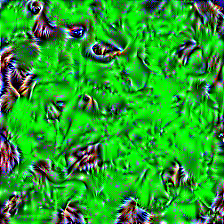

In [26]:
generated_image

In [29]:
generated_image_t_2, generated_image_2 =reconstruct_mix(
    content_image_t=content_image_t,
    style_image_t=style_image_t,
    content_layer=2,
    style_layers=list(range(20)),
    content_weight=0.9,
    num_iteration=3000
)

Iteration 1/3000, Loss: 432469901312.0
Iteration 2/3000, Loss: 314995456.0
Iteration 3/3000, Loss: 304477696.0
Iteration 4/3000, Loss: 296513600.0
Iteration 5/3000, Loss: 290047200.0
Iteration 6/3000, Loss: 284593120.0
Iteration 7/3000, Loss: 279874624.0
Iteration 8/3000, Loss: 275720384.0
Iteration 9/3000, Loss: 272013472.0
Iteration 10/3000, Loss: 268668800.0
Iteration 11/3000, Loss: 265623968.0
Iteration 12/3000, Loss: 262830080.0
Iteration 13/3000, Loss: 260249248.0
Iteration 14/3000, Loss: 257851344.0
Iteration 15/3000, Loss: 255612320.0
Iteration 16/3000, Loss: 253511136.0
Iteration 17/3000, Loss: 251530368.0
Iteration 18/3000, Loss: 249655632.0
Iteration 19/3000, Loss: 247875792.0
Iteration 20/3000, Loss: 246180016.0
Iteration 21/3000, Loss: 244559840.0
Iteration 22/3000, Loss: 243007008.0
Iteration 23/3000, Loss: 241515520.0
Iteration 24/3000, Loss: 240080288.0
Iteration 25/3000, Loss: 238695776.0
Iteration 26/3000, Loss: 237356832.0
Iteration 27/3000, Loss: 236059344.0
Iterati

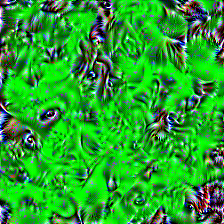

In [30]:
generated_image_2

In [31]:
generated_image_t_3, generated_image_3 =reconstruct_mix(
    content_image_t=content_image_t,
    style_image_t=style_image_t,
    content_layer=1,
    style_layers=list(range(15)),
    content_weight=0.95,
    num_iteration=1000
)

Iteration 1/1000, Loss: 578901508096.0
Iteration 2/1000, Loss: 399420288.0
Iteration 3/1000, Loss: 385716064.0
Iteration 4/1000, Loss: 375348384.0
Iteration 5/1000, Loss: 366956480.0
Iteration 6/1000, Loss: 359894912.0
Iteration 7/1000, Loss: 353797696.0
Iteration 8/1000, Loss: 348435168.0
Iteration 9/1000, Loss: 343654912.0
Iteration 10/1000, Loss: 339349408.0
Iteration 11/1000, Loss: 335438304.0
Iteration 12/1000, Loss: 331857472.0
Iteration 13/1000, Loss: 328555136.0
Iteration 14/1000, Loss: 325490624.0
Iteration 15/1000, Loss: 322632320.0
Iteration 16/1000, Loss: 319952416.0
Iteration 17/1000, Loss: 317430752.0
Iteration 18/1000, Loss: 315047744.0
Iteration 19/1000, Loss: 312788544.0
Iteration 20/1000, Loss: 310639520.0
Iteration 21/1000, Loss: 308588736.0
Iteration 22/1000, Loss: 306625088.0
Iteration 23/1000, Loss: 304741664.0
Iteration 24/1000, Loss: 302929952.0
Iteration 25/1000, Loss: 301184800.0
Iteration 26/1000, Loss: 299498688.0
Iteration 27/1000, Loss: 297865504.0
Iterati

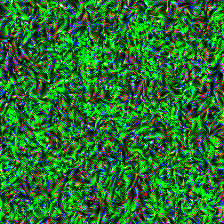

In [32]:
generated_image_t_3

As we see the Van Gogh's style (impasto and dynamic forms) appeared but in different colors, specifically green because most of the dog photograph is actually green because of the grass background.

However this is not the intended results, as the dog is not appearent. For now let's continue the generation based only on the content. (further hyperparametre tuning should be done later to mitigate this problem)

In [44]:
generated_image_t_4, generated_image_4 =reconstruct_mix(
    content_image_t=content_image_t,
    style_image_t=style_image_t,
    generated_image_t=generated_image_t_3,
    content_layer=1,
    style_layers=list(range(15)),
    content_weight=1,
    num_iteration=1000
)

Iteration 1/1000, Loss: 0.0
Iteration 2/1000, Loss: 97081496.0
Iteration 3/1000, Loss: 95078536.0
Iteration 4/1000, Loss: 92782848.0
Iteration 5/1000, Loss: 90353048.0
Iteration 6/1000, Loss: 87865208.0
Iteration 7/1000, Loss: 85340936.0
Iteration 8/1000, Loss: 82806112.0
Iteration 9/1000, Loss: 80266080.0
Iteration 10/1000, Loss: 77729920.0
Iteration 11/1000, Loss: 75201656.0
Iteration 12/1000, Loss: 72681200.0
Iteration 13/1000, Loss: 70178160.0
Iteration 14/1000, Loss: 67689464.0
Iteration 15/1000, Loss: 65216368.0
Iteration 16/1000, Loss: 62757612.0
Iteration 17/1000, Loss: 60324092.0
Iteration 18/1000, Loss: 57881784.0
Iteration 19/1000, Loss: 55402776.0
Iteration 20/1000, Loss: 52940996.0
Iteration 21/1000, Loss: 50504996.0
Iteration 22/1000, Loss: 48106216.0
Iteration 23/1000, Loss: 45748116.0
Iteration 24/1000, Loss: 43439388.0
Iteration 25/1000, Loss: 41186444.0
Iteration 26/1000, Loss: 38995108.0
Iteration 27/1000, Loss: 36877008.0
Iteration 28/1000, Loss: 34850596.0
Iteratio

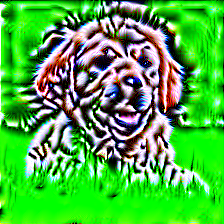

In [45]:
generated_image_4